In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
DirichletMultinomial = tfp.distributions.DirichletMultinomial

In [2]:
plt.style.use('ggplot')
tfd = tfp.distributions

In [3]:
def session_options(enable_gpu_ram_resizing=True):
  """Convenience function which sets common `tf.Session` options."""
  config = tf.ConfigProto()
  config.log_device_placement = True
  if enable_gpu_ram_resizing:
    # `allow_growth=True` makes it possible to connect multiple colabs to your
    # GPU. Otherwise the colab malloc's all GPU ram.
    config.gpu_options.allow_growth = True
  return config

def reset_sess(config=None):
  """Convenience function to create the TF graph and session, or reset them."""
  if config is None:
    config = session_options()
  tf.reset_default_graph()
  global sess
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession(config=config)

In [5]:
# For reproducibility
rng = np.random.RandomState(seed=45)
tf.random.set_seed(76)

# Precision
dtype = np.float64

# Number of training samples
num_samples = 50000

# Ground truth loc values which we will infer later on. The scale is 1.
true_loc = np.array([[-4, -4],
                     [0, 0],
                     [4, 4]], dtype)

true_components_num, dims = true_loc.shape

# Generate training samples from ground truth loc
true_hidden_component = rng.randint(0, true_components_num, num_samples)
observations = (true_loc[true_hidden_component]

                + rng.randn(num_samples, dims).astype(dtype))

In [40]:
alpha = [1., 2., 3.]
n = 2.
dist = DirichletMultinomial(total_count=n, concentration=alpha)

In [41]:
dist

<tfp.distributions.DirichletMultinomial 'DirichletMultinomial' batch_shape=[] event_shape=[3] dtype=float32>

In [57]:
d = dist.prob(tf.constant([1.,2,3]))
d

<tf.Tensor: shape=(), dtype=float32, numpy=0.00018037511>

In [52]:
tf.constant([1,2,3])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

In [37]:
d.T

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'T'

In [61]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

def tfNullLikelihood(pDsAll, altCounts):
    print("pDS are", pDsAll)
    print("altCounts are", altCounts)
    return tfd.Multinomial(probs=pDsAll).prob(altCounts)

def tfEffectLikelihood(nHypotheses, pDs, altCountsFlat):
    nGenes = altCountsFlat.shape[0]
    nConditions = altCountsFlat.shape[1]
    nHypothesesNonNull = nHypotheses - 1

    # nGenes x 1
    n = tf.reduce_sum(altCountsFlat, 1) #xCtrl + xCase1 + xCase2 + xCase12
    print("n", n)
    altCountsShaped = tf.broadcast_to(altCountsFlat, [
        nHypothesesNonNull, nGenes, nConditions])
    altCountsShaped = tf.transpose(altCountsShaped, [0, 1])

    altCountsShaped = tf.broadcast_to(altCountsFlat, [nHypothesesNonNull, nGenes, nConditions])
    altCountsShaped = tf.transpose(altCountsShaped, [0, 1])

    nShaped = tf.transpose(tf.broadcast_to(n, [nHypothesesNonNull, nGenes]))

    pDsum = tf.reduce_sum(pDs)
    pdsAll = tf.constant([1 - pDsum, *pDs])
    pdsAllShaped = tf.broadcast_to(pdsAll, [nHypothesesNonNull, nConditions])

    def likelihoodFn(alpha0, alpha1, alpha2, alphaBoth):
        concentrations = tf.constant([
            [alpha0, alpha1, alpha0, alpha1],  # H1
            [alpha0, alpha0, alpha2, alpha2],  # H2
            [alpha0, alpha1 + alphaBoth, alpha2 + alphaBoth,
                alpha1 + alpha2 + alphaBoth]  # H1&2&3
        ])

        concentrations = tf.broadcast_to(concentrations, [nGenes, nHypothesesNonNull, nConditions])
        concentrations = pdsAllShaped * concentrations

        # try to stay in the log space; avoid numeric underflow, until bayes factor calc
        return tfd.DirichletMultinomial(total_count=nShaped, concentration=concentrations).prob(altCountsShaped)

    return likelihoodFn, nullLikelihood(pDs, altCountsFlat)

def tfLikelihoodBivariateDM(altCountsFlat: tf.Tensor, pDs: tf.Tensor, trajectoryPis, trajectoryAlphas, trajectoryLLs):
    print(altCountsFlat.shape)

    # TODO: make this flexible for multivariate
    nHypotheses = 4
    nGenes = altCountsFlat.shape[0]

    likelihoodFn, allNull2, = effectLikelihood(nHypotheses, pDs, altCountsFlat)

    def jointLikelihood(params):
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")

        pi0 = 1.0 - (pi1 + pi2 + piBoth)

        if pi0 < 0:
            return float("inf")

        h0 = pi0 * allNull2

        trajectoryPis.append([pi1, pi2, piBoth])
        trajectoryAlphas.append([alpha0, alpha1, alpha2, alphaBoth])

        hs = tf.constant([[pi1, pi2, piBoth]]) * likelihoodFn(alpha0, alpha1, alpha2, alphaBoth)

        ll = tf.reduce_sum(-tf.math.log(h0 + tf.reduce_sum(hs, 1))
        trajectoryLLs.append(ll)
        return ll

    return jointLikelihood



SyntaxError: invalid syntax (<ipython-input-61-754b79bd55c9>, line 75)

In [38]:
DirichletMultinomial = tfp.distributions.DirichletMultinomial


In [39]:
DirichletMultinomial?

Init signature:
DirichletMultinomial(
    total_count,
    concentration,
    validate_args=False,
    allow_nan_stats=True,
    name='DirichletMultinomial',
)
Docstring:     
Dirichlet-Multinomial compound distribution.

The Dirichlet-Multinomial distribution is parameterized by a (batch of)
length-`K` `concentration` vectors (`K > 1`) and a `total_count` number of
trials, i.e., the number of trials per draw from the DirichletMultinomial. It
is defined over a (batch of) length-`K` vector `counts` such that
`tf.reduce_sum(counts, -1) = total_count`. The Dirichlet-Multinomial is
identically the Beta-Binomial distribution when `K = 2`.

#### Mathematical Details

The Dirichlet-Multinomial is a distribution over `K`-class counts, i.e., a
length-`K` vector of non-negative integer `counts = n = [n_0, ..., n_{K-1}]`.

The probability mass function (pmf) is,

```none
pmf(n; alpha, N) = Beta(alpha + n) / (prod_j n_j!) / Z
Z = Beta(alpha) / N!
```

where:

* `concentration = alpha = [alpha_0, .

In [58]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [59]:
tfd.Multinomial?

Init signature:
tfd.Multinomial(
    total_count,
    logits=None,
    probs=None,
    validate_args=False,
    allow_nan_stats=True,
    name='Multinomial',
)
Docstring:     
Multinomial distribution.

This Multinomial distribution is parameterized by `probs`, a (batch of)
length-`K` `prob` (probability) vectors (`K > 1`) such that
`tf.reduce_sum(probs, -1) = 1`, and a `total_count` number of trials, i.e.,
the number of trials per draw from the Multinomial. It is defined over a
(batch of) length-`K` vector `counts` such that
`tf.reduce_sum(counts, -1) = total_count`. The Multinomial is identically the
Binomial distribution when `K = 2`.

#### Mathematical Details

The Multinomial is a distribution over `K`-class counts, i.e., a length-`K`
vector of non-negative integer `counts = n = [n_0, ..., n_{K-1}]`.

The probability mass function (pmf) is,

```none
pmf(n; pi, N) = prod_j (pi_j)**n_j / Z
Z = (prod_j n_j!) / N!
```

where:
* `probs = pi = [pi_0, ..., pi_{K-1}]`, `pi_j > 0`, `sum_j 

In [ ]:
import tensorflow_probability
import numpy as np
tfd = tensorflow_probability.distributions
reset_sess()

# Upperbound on K
max_cluster_num = 4

# Define trainable variables.
mix_probs = tf.nn.softmax(
    tf.Variable(
        name='mix_probs',
        initial_value=np.ones([max_cluster_num], dtype) / max_cluster_num))

concentrations = tf.Variable(
    name='concentration',
    initial_value=np.random.uniform(
        low=1, #set around minimum value of sample value
        high=25000, #set around maximum value of sample value
        size=[max_cluster_num, dims]))

precision = tf.nn.softplus(tf.Variable(
    name='precision',
    initial_value=
    np.ones([max_cluster_num, dims], dtype=dtype)))

alpha = tf.nn.softplus(tf.Variable(
    name='alpha',
    initial_value=
    np.ones([1], dtype=dtype)))

training_vals = [mix_probs, alpha, loc, precision]


# Prior distributions of the training variables

#Use symmetric Dirichlet prior as finite approximation of Dirichlet process.
rv_symmetric_dirichlet_process = tfd.Dirichlet(
    concentration=np.ones(max_cluster_num, dtype) * alpha / max_cluster_num,
    name='rv_sdp')

rv_loc = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros([max_cluster_num, dims], dtype=dtype),
        scale=tf.ones([max_cluster_num, dims], dtype=dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_loc')


rv_precision = tfd.Independent(
    tfd.InverseGamma(
        concentration=np.ones([max_cluster_num, dims], dtype),
        rate=np.ones([max_cluster_num, dims], dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_precision')

rv_alpha = tfd.InverseGamma(
    concentration=np.ones([1], dtype=dtype),
    rate=np.ones([1]),
    name='rv_alpha')

# Define mixture model
rv_observations = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix_probs),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=loc,
        scale_diag=precision))

In [62]:
dtype = np.float64
dims = 4
components = 4
num_samples = 1000


In [63]:
bgmm = tfd.JointDistributionNamed(dict(
  mix_probs=tfd.Dirichlet(
    concentration=np.ones(components, dtype) / 10.),
  loc=tfd.Independent(
    tfd.DirichletMultinomial(
        loc=np.stack([
            -np.ones(dims, dtype),
            np.zeros(dims, dtype),
            np.ones(dims, dtype),
        ]),
        scale=tf.ones([components, dims], dtype)),
    reinterpreted_batch_ndims=2),
  precision=tfd.Independent(
    tfd.WishartTriL(
        df=5,
        scale_tril=np.stack([np.eye(dims, dtype=dtype)]*components),
        input_output_cholesky=True),
    reinterpreted_batch_ndims=1),
  s=lambda mix_probs: tfd.Sample(tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=mix_probs),
      components_distribution=tfd.DirichletMultinomial(
          loc=loc,
          chol_precision_tril=precision)),
      sample_shape=num_samples)
))

24.0


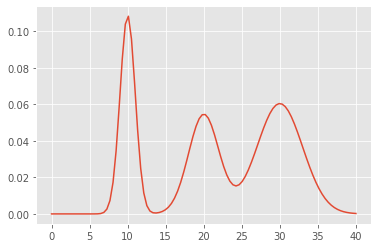

In [66]:
pi = np.array([0.3, 0.3, 0.5], dtype=np.float32)
mu = np.array([10, 20, 30], dtype=np.float32)
sigma = np.array([1, 2, 3], dtype=np.float32)
gmm = tfd.Mixture(
    cat=tfd.Categorical(probs=pi),
    components=[tfd.Normal(loc=m, scale=s) for m, s in zip(mu, sigma)]
)
x = np.linspace(0, 40, 100)
plt.plot(x, gmm.prob(x).numpy());
print(gmm.mean().numpy())  # 23.0

In [69]:
gmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=pi),
    components_distribution=tfd.Normal(loc=mu, scale=sigma)
)
gmm.mean().numpy()  # 23.0

24.0

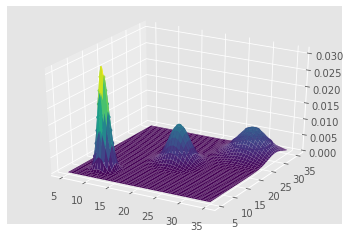

In [70]:
pi = np.array([0.2, 0.3, 0.5], dtype=np.float32)
mu = np.array([[10, 10],
               [20, 20],
               [30, 30]], dtype=np.float32)
sigma = np.array([[1, 1],
                  [2, 2],
                  [3, 3]], dtype=np.float32)
mvgmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=pi),
    components_distribution=tfd.DirichletMultinomial(
        loc=mu,
        scale_diag=sigma)
)
x = np.linspace(5, 35, 100)
y = np.linspace(5, 35, 100)
x, y = np.meshgrid(x, y)
data = np.stack((x.flatten(), y.flatten()), axis=1)
prob = mvgmm.prob(data).numpy()
ax = plt.axes(projection='3d')
plt.contour(x, y, prob.reshape((100, 100)));
ax.plot_surface(x, y, prob.reshape((100,100)), cmap='viridis');


In [74]:
 # The objective function
def sqrt_quadratic(x):
    return tf.sqrt(tf.reduce_sum(x ** 2, axis=-1))

start = tf.constant([6.0, -21.0])  # Starting point for the search.
optim_results = tfp.optimizer.nelder_mead_minimize(
    sqrt_quadratic, initial_vertex=start, func_tolerance=1e-8,
    batch_evaluate_objective=True)

# Check that the search converged
assert(optim_results.converged)
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, np.array([0.0, 0.0]),
                            atol=1e-7)
# Print out the total number of function evaluations it took.
print("Function evaluations: %d" % optim_results.num_objective_evaluations)



Function evaluations: 154


In [76]:
x = tf.constant([6.0, -21.0]) 
tf.sqrt(tf.reduce_sum(x ** 2, axis=-1))

<tf.Tensor: shape=(), dtype=float32, numpy=21.84033>

In [80]:
tf.reduce_sum(x ** 2, axis=0)

<tf.Tensor: shape=(), dtype=float32, numpy=477.0>

In [81]:
%matplotlib inline


import contextlib
import functools
import os
import time

import numpy as np
import pandas as pd
import scipy as sp
from six.moves import urllib
from sklearn import preprocessing

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

In [82]:


CACHE_DIR = os.path.join(os.sep, 'tmp', 'datasets')


def make_val_and_grad_fn(value_fn):
  @functools.wraps(value_fn)
  def val_and_grad(x):
    return tfp.math.value_and_gradient(value_fn, x)
  return val_and_grad


@contextlib.contextmanager
def timed_execution():
  t0 = time.time()
  yield
  dt = time.time() - t0
  print('Evaluation took: %f seconds' % dt)


def np_value(tensor):
  """Get numpy value out of possibly nested tuple of tensors."""
  if isinstance(tensor, tuple):
    return type(tensor)(*(np_value(t) for t in tensor))
  else:
    return tensor.numpy()

def run(optimizer):
  """Run an optimizer and measure it's evaluation time."""
  optimizer()  # Warmup.
  with timed_execution():
    result = optimizer()
  return np_value(result)

In [83]:
# Fix numpy seed for reproducibility
np.random.seed(12345)

# The objective must be supplied as a function that takes a single
# (Tensor) argument and returns a tuple. The first component of the
# tuple is the value of the objective at the supplied point and the
# second value is the gradient at the supplied point. The value must
# be a scalar and the gradient must have the same shape as the
# supplied argument.

# The `make_val_and_grad_fn` decorator helps transforming a function
# returning the objective value into one that returns both the gradient
# and the value. It also works for both eager and graph mode.

dim = 10
minimum = np.ones([dim])
scales = np.exp(np.random.randn(dim))

@make_val_and_grad_fn
def quadratic(x):
  return tf.reduce_sum(scales * (x - minimum) ** 2, axis=-1)

# The minimization routine also requires you to supply an initial
# starting point for the search. For this example we choose a random
# starting point.
start = np.random.randn(dim)

# Finally an optional argument called tolerance let's you choose the
# stopping point of the search. The tolerance specifies the maximum
# (supremum) norm of the gradient vector at which the algorithm terminates.
# If you don't have a specific need for higher or lower accuracy, leaving
# this parameter unspecified (and hence using the default value of 1e-8)
# should be good enough.
tolerance = 1e-10

@tf.function
def quadratic_with_lbfgs():
  return tfp.optimizer.lbfgs_minimize(
    quadratic,
    initial_position=tf.constant(start),
    tolerance=tolerance)

results = run(quadratic_with_lbfgs)

# The optimization results contain multiple pieces of information. The most
# important fields are: 'converged' and 'position'.
# Converged is a boolean scalar tensor. As the name implies, it indicates
# whether the norm of the gradient at the final point was within tolerance.
# Position is the location of the minimum found. It is important to check
# that converged is True before using the value of the position.

print('L-BFGS Results')
print('Converged:', results.converged)
print('Location of the minimum:', results.position)
print('Number of iterations:', results.num_iterations)

Evaluation took: 0.015011 seconds
L-BFGS Results
Converged: True
Location of the minimum: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of iterations: 10
